In [1]:
# === Step 1: Import Libraries ===
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# === Step 2: Data Preparation ===
df = pd.read_csv("Final_v2_processed.csv")
test_df = pd.read_csv("Final_test_v2_processed.csv")

le = LabelEncoder()
df["addr_state"] = le.fit_transform(df["addr_state"])
test_df["addr_state"] = le.transform(test_df["addr_state"])

target_col = "loan_status"
feature_cols = [col for col in df.columns if col != target_col and col != "id"]

X = df[feature_cols].values
y = df[target_col].values
X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === 判断是二分类还是多分类 ===
num_classes = len(np.unique(y_train))
print(f"任务类别数：{num_classes}")
if num_classes == 2:
    print("✅ 这是一个二分类任务")
else:
    print("🔁 这是一个多分类任务")

class LoanDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = LoanDataset(X_train, y_train)
val_dataset = LoanDataset(X_val, y_val)
test_dataset = LoanDataset(X_test, y_test)


任务类别数：2
✅ 这是一个二分类任务


In [3]:
# === Step 3: Define Logistic Regression Model ===
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 2)

    def forward(self, x):
        return self.linear(x)

In [4]:
# === Step 4: Optuna Hyperparameter Tuning ===
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = LogisticRegressionModel(input_size=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(10):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.numpy())
            y_true.extend(y_batch.numpy())

    return 1 - f1_score(y_true, y_pred, average="weighted")

study = optuna.create_study()
study.optimize(objective, n_trials=20)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

[I 2025-04-29 21:31:29,844] A new study created in memory with name: no-name-cdd889df-0f82-4456-9ef1-0d1820adb45a
[I 2025-04-29 21:32:06,772] Trial 0 finished with value: 0.03363095715494335 and parameters: {'lr': 0.0003171673229693628, 'batch_size': 32}. Best is trial 0 with value: 0.03363095715494335.
[I 2025-04-29 21:32:27,296] Trial 1 finished with value: 0.03195249806123546 and parameters: {'lr': 0.005902501223852174, 'batch_size': 64}. Best is trial 1 with value: 0.03195249806123546.
[I 2025-04-29 21:33:03,201] Trial 2 finished with value: 0.030845484056395645 and parameters: {'lr': 0.02220902878149304, 'batch_size': 32}. Best is trial 2 with value: 0.030845484056395645.
[I 2025-04-29 21:33:15,662] Trial 3 finished with value: 0.03247069866790042 and parameters: {'lr': 0.0028645601161125275, 'batch_size': 128}. Best is trial 2 with value: 0.030845484056395645.
[I 2025-04-29 21:33:27,655] Trial 4 finished with value: 0.03094988749260863 and parameters: {'lr': 0.055753828767834565,

Best hyperparameters: {'lr': 0.015007262326949282, 'batch_size': 32}


In [5]:
# === Step 5: Train Final Model ===
batch_size = best_params['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = LogisticRegressionModel(input_size=X.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in range(20):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    predicted_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            predicted_labels.extend(preds.numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

Epoch 1 - Train Loss: 0.1159, Val Loss: 0.0947
Epoch 2 - Train Loss: 0.0941, Val Loss: 0.0938
Epoch 3 - Train Loss: 0.0923, Val Loss: 0.0916
Epoch 4 - Train Loss: 0.0913, Val Loss: 0.0948
Epoch 5 - Train Loss: 0.0910, Val Loss: 0.0876
Epoch 6 - Train Loss: 0.0903, Val Loss: 0.0893
Epoch 7 - Train Loss: 0.0902, Val Loss: 0.0930
Epoch 8 - Train Loss: 0.0899, Val Loss: 0.0911
Epoch 9 - Train Loss: 0.0896, Val Loss: 0.0913
Epoch 10 - Train Loss: 0.0896, Val Loss: 0.0865
Epoch 11 - Train Loss: 0.0895, Val Loss: 0.0951
Epoch 12 - Train Loss: 0.0890, Val Loss: 0.0946
Epoch 13 - Train Loss: 0.0892, Val Loss: 0.0866
Epoch 14 - Train Loss: 0.0888, Val Loss: 0.0900
Epoch 15 - Train Loss: 0.0887, Val Loss: 0.0899
Early stopping triggered at epoch 15


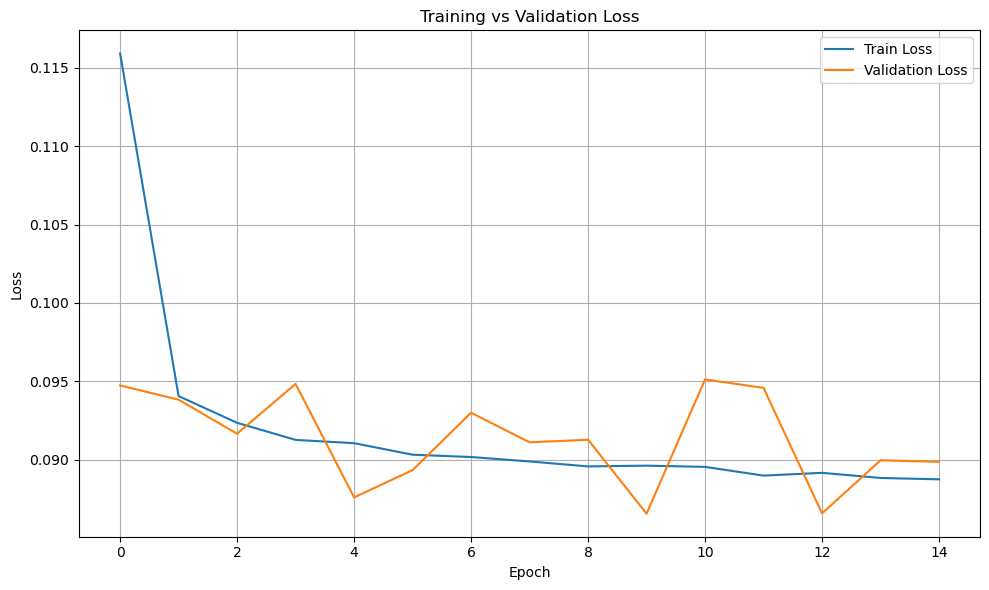

In [6]:
# === Step 6: Visualize Training and Validation Loss ===
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

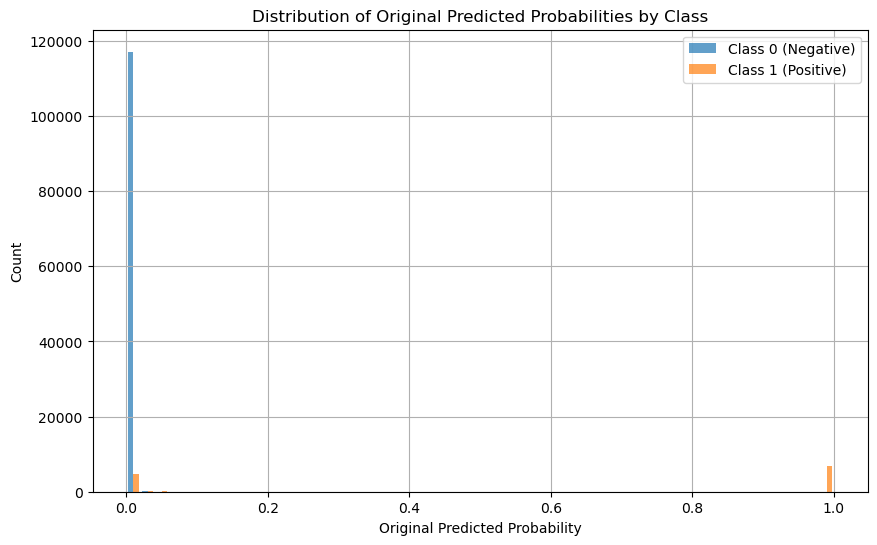

原始预测概率分布分析:
概率<0.01的样本数: 121393 (93.78%)
概率>0.99的样本数: 6793 (5.25%)
总样本数: 129438

=== 开始模型校准 ===
最优温度参数: 5.9517


C:\Users\dbn\AppData\Local\Temp\ipykernel_3412\2467363912.py:79: RuntimeWarning: divide by zero encountered in log
  logits = np.log(probs / (1 - probs + 1e-12))


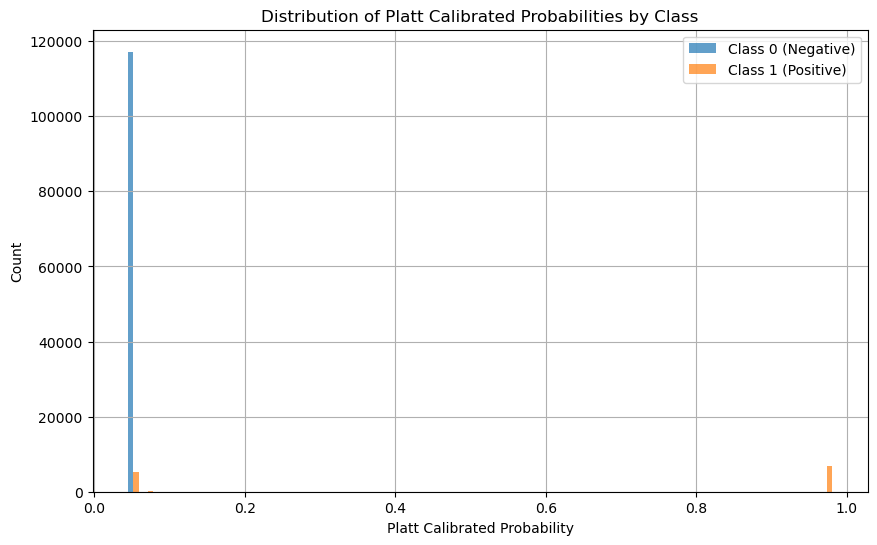

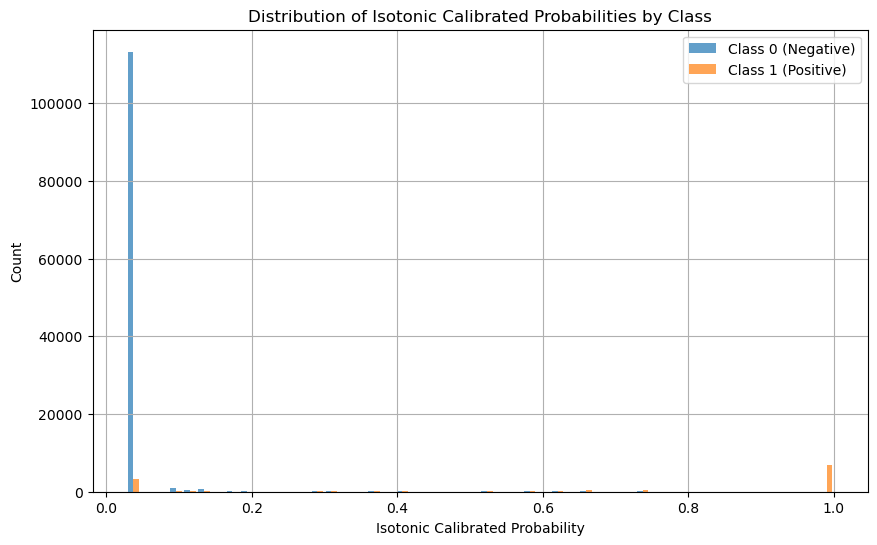

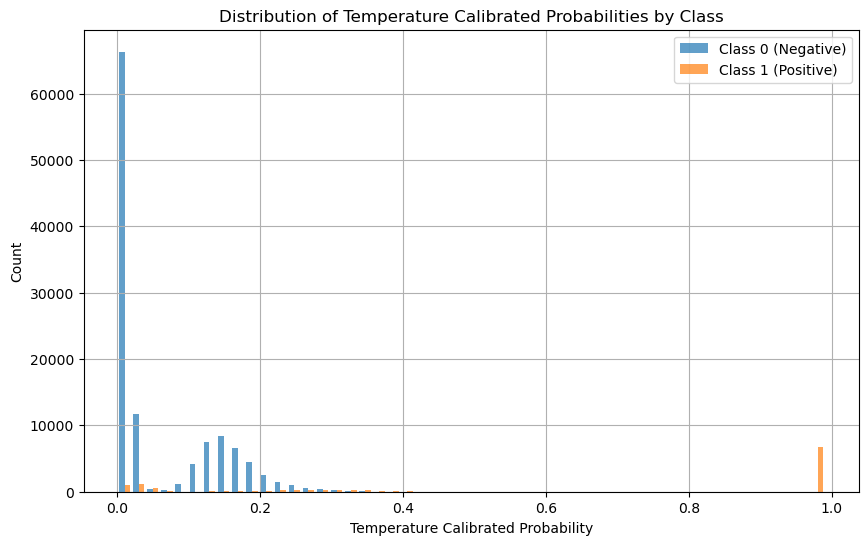

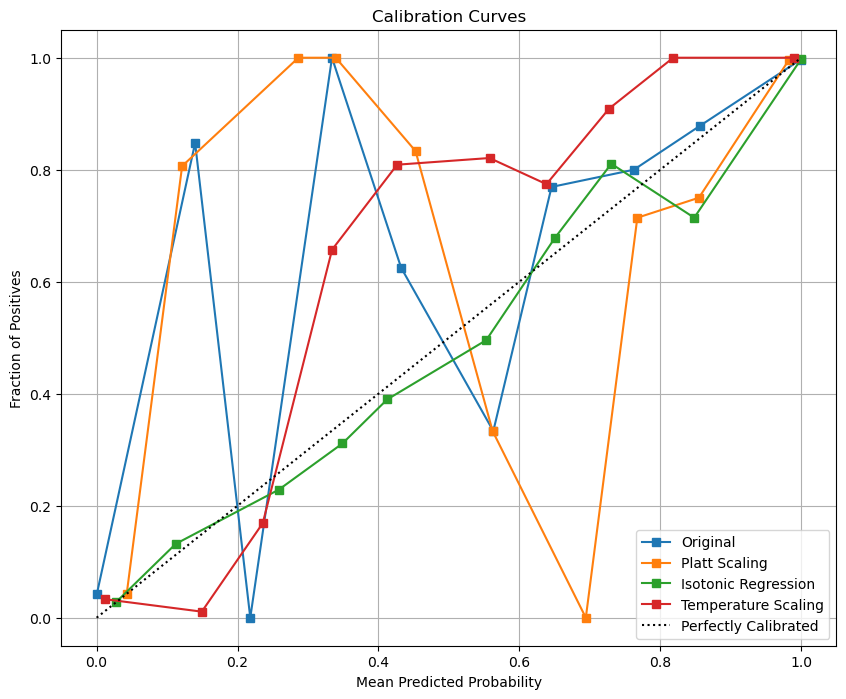


=== 原始模型 ===
F1最优阈值: 0.0100, 最佳F1分数: 0.7619
G-mean最优阈值: 0.0100, 最佳G-mean: 0.7942

=== Platt Scaling校准 ===
F1最优阈值: 0.0496, 最佳F1分数: 0.7461
G-mean最优阈值: 0.0496, 最佳G-mean: 0.7755

=== Isotonic Regression校准 ===
F1最优阈值: 0.4159, 最佳F1分数: 0.7726
G-mean最优阈值: 0.0892, 最佳G-mean: 0.8438

=== 温度缩放校准 ===
F1最优阈值: 0.2773, 最佳F1分数: 0.7737
G-mean最优阈值: 0.2179, 最佳G-mean: 0.8437

=== 最佳校准方法 ===
F1最佳方法: Temperature Scaling (F1=0.7737, 阈值=0.2773)
G-mean最佳方法: Isotonic Regression (G-mean=0.8438, 阈值=0.0892)


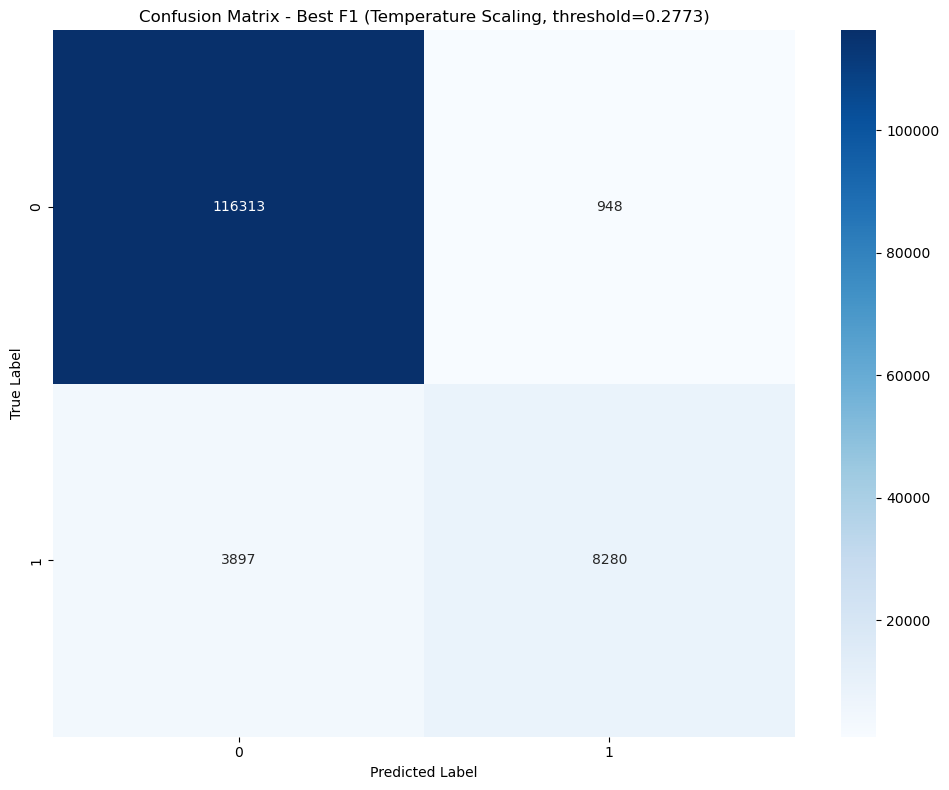


=== 最佳F1方法 (Temperature Scaling) 的详细指标 ===
阈值: 0.2773
精确率 (Precision): 0.8973
召回率 (Recall): 0.6800
特异度 (Specificity): 0.9919
F1分数: 0.7737
G-mean: 0.8213


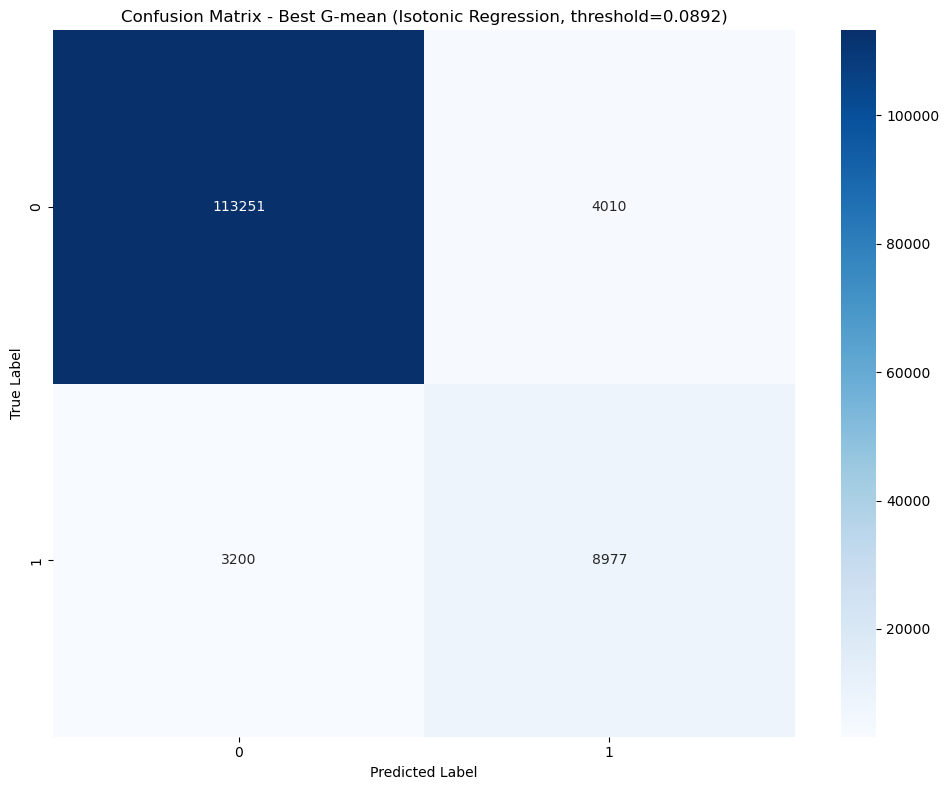


=== 最佳G-mean方法 (Isotonic Regression) 的详细指标 ===
阈值: 0.0892
精确率 (Precision): 0.6912
召回率 (Recall): 0.7372
特异度 (Specificity): 0.9658
F1分数: 0.7135
G-mean: 0.8438


In [9]:
# === Step 7: 评估和模型校准 ===
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model.load_state_dict(best_model_state)
model.eval()
test_loader = DataLoader(test_dataset, batch_size=64)

# 收集原始预测结果
y_pred, y_true = [], []
y_prob = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        y_true.extend(y_batch.numpy())
        y_pred.extend(preds.numpy())
        y_prob.extend(probs[:, 1].numpy())  # 预测为 class=1 的概率

# 将列表转换为numpy数组以便操作
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# 绘制原始预测概率分布
plt.figure(figsize=(10, 6))
plt.hist([y_prob[y_true==0], y_prob[y_true==1]], bins=50, 
         label=['Class 0 (Negative)', 'Class 1 (Positive)'], alpha=0.7)
plt.xlabel('Original Predicted Probability')
plt.ylabel('Count')
plt.title('Distribution of Original Predicted Probabilities by Class')
plt.legend()
plt.grid(True)
plt.show()

print("原始预测概率分布分析:")
near_zero = sum(y_prob < 0.01)
near_one = sum(y_prob > 0.99)
total = len(y_prob)
print(f"概率<0.01的样本数: {near_zero} ({near_zero/total*100:.2f}%)")
print(f"概率>0.99的样本数: {near_one} ({near_one/total*100:.2f}%)")
print(f"总样本数: {total}")

# === 模型校准 ===
print("\n=== 开始模型校准 ===")

# 1. Platt Scaling 校准方法
# 准备训练校准器的数据 (使用部分测试数据)
calib_indices = np.random.choice(len(y_true), size=min(len(y_true), 10000), replace=False)
X_calib = X_test[calib_indices]
y_calib = y_true[calib_indices]
original_probs_calib = y_prob[calib_indices]

# 使用逻辑回归进行Platt Scaling
platt_calibrator = LogisticRegression(solver='lbfgs')
platt_calibrator.fit(original_probs_calib.reshape(-1, 1), y_calib)

# 应用校准器到所有测试数据
platt_calibrated_probs = platt_calibrator.predict_proba(y_prob.reshape(-1, 1))[:, 1]

# 2. Isotonic Regression 校准方法
isotonic_calibrator = IsotonicRegression(out_of_bounds='clip')
isotonic_calibrator.fit(original_probs_calib, y_calib)

# 应用校准器到所有测试数据
isotonic_calibrated_probs = isotonic_calibrator.predict(y_prob)

# 3. 温度缩放校准方法
# 使用简单的温度参数进行校准
def temperature_scaling(probs, temperature=1.0):
    # 从概率转换到logits
    logits = np.log(probs / (1 - probs + 1e-12))
    # 应用温度
    calibrated_logits = logits / temperature
    # 转换回概率
    calibrated_probs = 1 / (1 + np.exp(-calibrated_logits))
    return calibrated_probs

# 找到最佳温度参数
from scipy.optimize import minimize

def nll_loss(temperature, probs, labels):
    """
    负对数似然损失函数，用于优化温度参数
    """
    calibrated_probs = temperature_scaling(probs, temperature)
    # 防止出现0或1，会导致log计算出无穷大
    calibrated_probs = np.clip(calibrated_probs, 1e-12, 1 - 1e-12)
    loss = -(labels * np.log(calibrated_probs) + (1 - labels) * np.log(1 - calibrated_probs)).mean()
    return loss

# 优化温度参数
temperature_opt_result = minimize(
    nll_loss,
    x0=np.array([1.0]),
    args=(original_probs_calib, y_calib),
    method='Nelder-Mead',
    options={'xatol': 1e-4}
)
optimal_temperature = temperature_opt_result.x[0]
print(f"最优温度参数: {optimal_temperature:.4f}")

# 应用温度缩放校准
temp_calibrated_probs = temperature_scaling(y_prob, optimal_temperature)

# 绘制校准后的预测概率分布
plt.figure(figsize=(10, 6))
plt.hist([platt_calibrated_probs[y_true==0], platt_calibrated_probs[y_true==1]], bins=50, 
         label=['Class 0 (Negative)', 'Class 1 (Positive)'], alpha=0.7)
plt.xlabel('Platt Calibrated Probability')
plt.ylabel('Count')
plt.title('Distribution of Platt Calibrated Probabilities by Class')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist([isotonic_calibrated_probs[y_true==0], isotonic_calibrated_probs[y_true==1]], bins=50, 
         label=['Class 0 (Negative)', 'Class 1 (Positive)'], alpha=0.7)
plt.xlabel('Isotonic Calibrated Probability')
plt.ylabel('Count')
plt.title('Distribution of Isotonic Calibrated Probabilities by Class')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist([temp_calibrated_probs[y_true==0], temp_calibrated_probs[y_true==1]], bins=50, 
         label=['Class 0 (Negative)', 'Class 1 (Positive)'], alpha=0.7)
plt.xlabel('Temperature Calibrated Probability')
plt.ylabel('Count')
plt.title('Distribution of Temperature Calibrated Probabilities by Class')
plt.legend()
plt.grid(True)
plt.show()

# 绘制校准曲线来评估校准效果
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 8))
# 原始模型的校准曲线
fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Original")

# Platt Scaling校准曲线
fraction_of_positives_platt, mean_predicted_value_platt = calibration_curve(
    y_true, platt_calibrated_probs, n_bins=10)
plt.plot(mean_predicted_value_platt, fraction_of_positives_platt, "s-", label="Platt Scaling")

# Isotonic Regression校准曲线
fraction_of_positives_iso, mean_predicted_value_iso = calibration_curve(
    y_true, isotonic_calibrated_probs, n_bins=10)
plt.plot(mean_predicted_value_iso, fraction_of_positives_iso, "s-", label="Isotonic Regression")

# 温度缩放校准曲线
fraction_of_positives_temp, mean_predicted_value_temp = calibration_curve(
    y_true, temp_calibrated_probs, n_bins=10)
plt.plot(mean_predicted_value_temp, fraction_of_positives_temp, "s-", label="Temperature Scaling")

# 理想的校准曲线
plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title("Calibration Curves")
plt.grid(True)
plt.show()

# === 寻找最优阈值函数 ===
def find_optimal_threshold(y_true, y_prob, metric_name='f1', num_thresholds=100):
    """
    寻找优化给定指标的最佳阈值
    
    参数:
    -----------
    y_true : array-like
        真实标签
    y_prob : array-like
        预测概率
    metric_name : str, default='f1'
        要优化的指标。选项: 'f1', 'gmean'
    num_thresholds : int, default=100
        要尝试的阈值数量
    
    返回:
    --------
    optimal_threshold : float
        最大化指标的阈值
    best_metric : float
        达到的最佳指标值
    """
    thresholds = np.linspace(0.01, 0.99, num_thresholds)
    best_metric = 0
    optimal_threshold = 0.5
    
    for threshold in thresholds:
        y_pred_th = (np.array(y_prob) >= threshold).astype(int)
        
        if metric_name == 'f1':
            metric_value = f1_score(y_true, y_pred_th)
        elif metric_name == 'gmean':
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred_th).ravel()
            sensitivity = tp / (tp + fn + 1e-6)  # 真阳性率
            specificity = tn / (tn + fp + 1e-6)  # 真阴性率
            metric_value = np.sqrt(sensitivity * specificity)
        
        if metric_value > best_metric:
            best_metric = metric_value
            optimal_threshold = threshold
    
    return optimal_threshold, best_metric

# === 为每种校准方法分别找出最优阈值 ===
# 原始模型
orig_f1_threshold, orig_best_f1 = find_optimal_threshold(y_true, y_prob, 'f1')
orig_gmean_threshold, orig_best_gmean = find_optimal_threshold(y_true, y_prob, 'gmean')

# Platt校准
platt_f1_threshold, platt_best_f1 = find_optimal_threshold(y_true, platt_calibrated_probs, 'f1')
platt_gmean_threshold, platt_best_gmean = find_optimal_threshold(y_true, platt_calibrated_probs, 'gmean')

# Isotonic校准
iso_f1_threshold, iso_best_f1 = find_optimal_threshold(y_true, isotonic_calibrated_probs, 'f1')
iso_gmean_threshold, iso_best_gmean = find_optimal_threshold(y_true, isotonic_calibrated_probs, 'gmean')

# 温度校准
temp_f1_threshold, temp_best_f1 = find_optimal_threshold(y_true, temp_calibrated_probs, 'f1')
temp_gmean_threshold, temp_best_gmean = find_optimal_threshold(y_true, temp_calibrated_probs, 'gmean')

# 输出所有方法的最优阈值和性能
print("\n=== 原始模型 ===")
print(f"F1最优阈值: {orig_f1_threshold:.4f}, 最佳F1分数: {orig_best_f1:.4f}")
print(f"G-mean最优阈值: {orig_gmean_threshold:.4f}, 最佳G-mean: {orig_best_gmean:.4f}")

print("\n=== Platt Scaling校准 ===")
print(f"F1最优阈值: {platt_f1_threshold:.4f}, 最佳F1分数: {platt_best_f1:.4f}")
print(f"G-mean最优阈值: {platt_gmean_threshold:.4f}, 最佳G-mean: {platt_best_gmean:.4f}")

print("\n=== Isotonic Regression校准 ===")
print(f"F1最优阈值: {iso_f1_threshold:.4f}, 最佳F1分数: {iso_best_f1:.4f}")
print(f"G-mean最优阈值: {iso_gmean_threshold:.4f}, 最佳G-mean: {iso_best_gmean:.4f}")

print("\n=== 温度缩放校准 ===")
print(f"F1最优阈值: {temp_f1_threshold:.4f}, 最佳F1分数: {temp_best_f1:.4f}")
print(f"G-mean最优阈值: {temp_gmean_threshold:.4f}, 最佳G-mean: {temp_best_gmean:.4f}")

# === 选择最佳的校准方法 ===
# 比较所有方法的F1和G-mean
methods = ['Original', 'Platt Scaling', 'Isotonic Regression', 'Temperature Scaling']
f1_scores = [orig_best_f1, platt_best_f1, iso_best_f1, temp_best_f1]
gmean_scores = [orig_best_gmean, platt_best_gmean, iso_best_gmean, temp_best_gmean]
f1_thresholds = [orig_f1_threshold, platt_f1_threshold, iso_f1_threshold, temp_f1_threshold]
gmean_thresholds = [orig_gmean_threshold, platt_gmean_threshold, iso_gmean_threshold, temp_gmean_threshold]

# 找出F1和G-mean最高的方法
best_f1_method_idx = np.argmax(f1_scores)
best_gmean_method_idx = np.argmax(gmean_scores)

print("\n=== 最佳校准方法 ===")
print(f"F1最佳方法: {methods[best_f1_method_idx]} (F1={f1_scores[best_f1_method_idx]:.4f}, 阈值={f1_thresholds[best_f1_method_idx]:.4f})")
print(f"G-mean最佳方法: {methods[best_gmean_method_idx]} (G-mean={gmean_scores[best_gmean_method_idx]:.4f}, 阈值={gmean_thresholds[best_gmean_method_idx]:.4f})")

# === 使用最佳校准方法和阈值生成最终混淆矩阵 ===
# 使用F1最佳的校准方法和阈值
if best_f1_method_idx == 0:
    best_f1_probs = y_prob
elif best_f1_method_idx == 1:
    best_f1_probs = platt_calibrated_probs
elif best_f1_method_idx == 2:
    best_f1_probs = isotonic_calibrated_probs
else:
    best_f1_probs = temp_calibrated_probs

best_f1_preds = (best_f1_probs >= f1_thresholds[best_f1_method_idx]).astype(int)
cm_best_f1 = confusion_matrix(y_true, best_f1_preds)

# 使用G-mean最佳的校准方法和阈值
if best_gmean_method_idx == 0:
    best_gmean_probs = y_prob
elif best_gmean_method_idx == 1:
    best_gmean_probs = platt_calibrated_probs
elif best_gmean_method_idx == 2:
    best_gmean_probs = isotonic_calibrated_probs
else:
    best_gmean_probs = temp_calibrated_probs

best_gmean_preds = (best_gmean_probs >= gmean_thresholds[best_gmean_method_idx]).astype(int)
cm_best_gmean = confusion_matrix(y_true, best_gmean_preds)

# 绘制最佳F1校准的混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm_best_f1, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Best F1 ({methods[best_f1_method_idx]}, threshold={f1_thresholds[best_f1_method_idx]:.4f})")
plt.tight_layout()
plt.show()

# 计算和显示详细指标
tn, fp, fn, tp = cm_best_f1.ravel()
precision = tp / (tp + fp + 1e-6)
recall = tp / (tp + fn + 1e-6)
specificity = tn / (tn + fp + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)
gmean = np.sqrt(recall * specificity)

print(f"\n=== 最佳F1方法 ({methods[best_f1_method_idx]}) 的详细指标 ===")
print(f"阈值: {f1_thresholds[best_f1_method_idx]:.4f}")
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"特异度 (Specificity): {specificity:.4f}")
print(f"F1分数: {f1:.4f}")
print(f"G-mean: {gmean:.4f}")

# 绘制最佳G-mean校准的混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm_best_gmean, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Best G-mean ({methods[best_gmean_method_idx]}, threshold={gmean_thresholds[best_gmean_method_idx]:.4f})")
plt.tight_layout()
plt.show()

# 计算和显示详细指标
tn, fp, fn, tp = cm_best_gmean.ravel()
precision = tp / (tp + fp + 1e-6)
recall = tp / (tp + fn + 1e-6)
specificity = tn / (tn + fp + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)
gmean = np.sqrt(recall * specificity)

print(f"\n=== 最佳G-mean方法 ({methods[best_gmean_method_idx]}) 的详细指标 ===")
print(f"阈值: {gmean_thresholds[best_gmean_method_idx]:.4f}")
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"特异度 (Specificity): {specificity:.4f}")
print(f"F1分数: {f1:.4f}")
print(f"G-mean: {gmean:.4f}")